In [350]:
import pandas as pd
import os, sys
from collections import defaultdict
import numpy as np
from sklearn.svm import LinearSVC
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [415]:
network = pd.read_csv('../data/network/vertex_attributes.csv')

network.shape

(1646, 16)

### Load Vertex Properties

In [466]:
cols = [u'name', u'degree',  u'in', u'out', u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'avg_neighborhood', u'authority', u'hub', u'clustering_coef']
network = network[cols]
network['name'] = network['name'].astype(str)
network['percent-out'] = network['out'].div(network['degree'])
# # network['name'] = [col.split('@')[0] for col in network['name']]
# network.head()

### Global Network Measures

In [ ]:
VERTICES: 1646 
EDGES: 4924
GLOBAL CC 0.0418348603048
AVG PATH LENGTH 2.74013916003
CLIQUES 138340
CLIQUE NO 14
DIAMETER 22.0
RECIPROCITY 0.245735174655
LARGEST CLUSTER SIZE 378 Vertices, 2708 Edges

ONLY ASKED QUETIONS: 464
ONLY ANSWER ANSWERED: 764
ASKED AND ANSWER: 415

In [423]:
cols = [u'name', u'degree',  u'in', u'out', u'core', u'core-in', u'core-out', u'closeness', u'betweenness', u'eigen_centrality', u'pagerank', u'neighborhood', u'avg_neighborhood', u'authority', u'hub', u'clustering_coef']
network = network[cols]
network.apply(pd.to_numeric, errors='ignore')
print network.describe().round(4).loc[['mean', 'std', 'min', 'max']].T

                       mean         std     min          max
degree               5.9830     30.6500  0.0000     895.0000
in                   2.9915     15.3362  0.0000     417.0000
out                  2.9915     15.7134  0.0000     478.0000
core                 3.1422      3.9024  0.0000      23.0000
core-in              1.3621      2.1560  0.0000      12.0000
core-out             1.4216      1.9871  0.0000      10.0000
closeness            0.0492      0.0054  0.0006       0.0537
betweenness       1349.3092  12844.0691  0.0000  383864.1714
eigen_centrality     0.0050      0.0368  0.0000       1.0000
pagerank             0.0006      0.0043  0.0002       0.1336
neighborhood         6.2479     24.9207  1.0000     727.0000
avg_neighborhood  1431.9329   1726.0096  1.0000    5802.0000
authority            0.0029      0.0291  0.0000       1.0000
hub                  0.0070      0.0421  0.0000       1.0000
clustering_coef      0.9397      0.6718  0.0000       2.0000


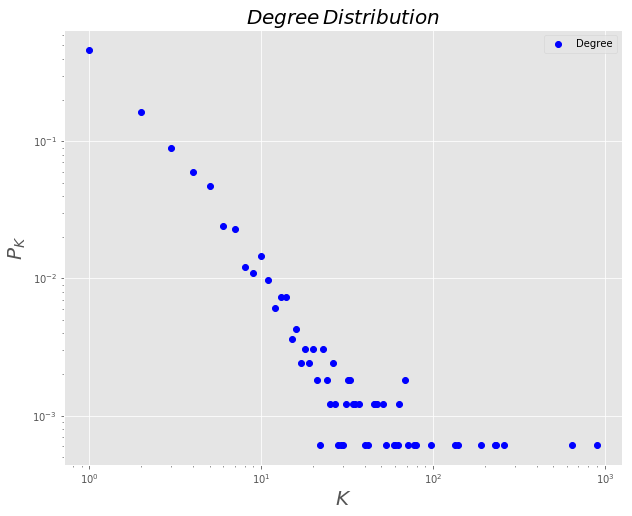

In [412]:
plotDegreeDistribution(network['degree'])

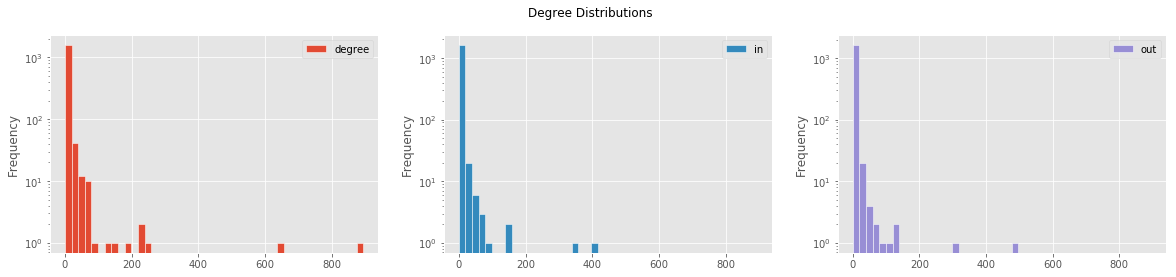

In [424]:
title = 'Degree Distributions'
degrees = network[['degree', 'in', 'out']]
degrees.plot(kind='hist', subplots=True, layout=(1,3), title=title, log=True, figsize=(20, 4), bins=45, edgecolor='w')
# plt.plot()
plt.show()

In [459]:
only_in = network['in'] > 0
no_out = network['out'] == 0

only_out = network['out'] > 0
no_in = network['in'] == 0

ask = network['in'] > 0
answer = network['out'] > 0

only_ask = network[(only_in & no_out)]
only_answer = network[(only_out & no_in)]
ask_answer = network[(ask & answer)]

print "ONLY ASK:", only_ask.shape[0]
print "ONLY ANSWER:", only_answer.shape[0]
print "ASK AND ANSWER:", ask_answer.shape[0]

ONLY ASK: 464
ONLY ANSWER: 764
ASK AND ANSWER: 415


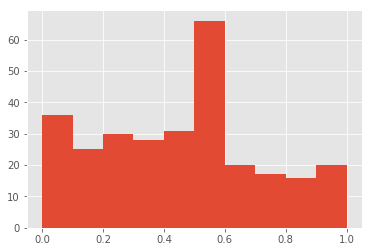

In [572]:
gt_three = network[network['degree'] >= 6]#['degree'].describe().loc[['count']]
gt_three['percent-out'].hist()

In [550]:
gt_three.shape

(249, 17)

### Add column for whether or not user is in the organizers group

In [363]:
edges = pd.read_csv('../data/network/plots_edgelist.csv')
plots_org = edges[edges['fid'] == 'plots-organizers']
organizers = pd.concat([plots_org['source'], plots_org['target']])
network['org'] = network['name'].isin(organizers)
# network.head()

### Label users as primaraly "question askers", "question answerers", or "both"

In [585]:
gt_three['percent-out'].describe(percentiles=[.33, .5, .66])

count    289.000000
mean       0.448234
std        0.275234
min        0.000000
33%        0.333333
50%        0.461538
66%        0.555556
max        1.000000
Name: percent-out, dtype: float64

In [587]:
gt_three['ans'] = gt_three['percent-out'] > .55
gt_three['ask'] = gt_three['percent-out'] < .33
gt_three['both'] = (gt_three['ans'] == False) & (gt_three['ask'] == False)
gt_three['org'] = gt_three['name'].isin(organizers)

### Sepperate features and labels

In [588]:
gt_feature_cols = gt_three.columns[1:-4]
gt_labels_cols = gt_three.columns[-4:]

gt_features = gt_three[gt_feature_cols]
gt_labels = gt_three[gt_labels_cols]
print gt_features.shape, gt_labels.shape

(289, 16) (289, 4)


### Normalize the data

In [589]:
gt_min_max_scaler = preprocessing.MinMaxScaler()
gt_feat_scaled = min_max_scaler.fit_transform(gt_features)
gt_feat_norm = pd.DataFrame(gt_feat_scaled, columns=gt_features.columns)
# gt_feat_norm.head()

### Remove "core-in" and "core-out" features

### LinearSVC for Question Askers

In [591]:
gt_ask_clf = LinearSVC(random_state=0)
gt_ask_clf.fit(gt_feat_norm, gt_labels['ask'])

gt_coef = gt_ask_clf.coef_.ravel()

gt_importance = pd.DataFrame(gt_coef, index=gt_feat_norm.columns, columns=['value'])#, columns=features.columns)

gt_pos_class = gt_importance[gt_importance['value'] > 0]
gt_neg_class = gt_importance[gt_importance['value'] < 0]

print 'ACCURACY:', gt_ask_clf.score(gt_feat_norm, gt_labels['ask'])
print ''
print gt_pos_class.sort_values(by='value', ascending=False)
print ''
print gt_neg_class.sort_values(by='value', ascending=True)

ACCURACY: 0.750865051903

                     value
in                2.362010
closeness         0.498460
eigen_centrality  0.407191
pagerank          0.356323
authority         0.268577

                     value
out              -2.503169
hub              -1.892844
core             -1.211290
clustering_coef  -0.616342
betweenness      -0.430050
avg_neighborhood -0.323419
degree           -0.238166
neighborhood     -0.111775


In [621]:
ask_cols = ['in', 'closeness', 'eigen_centrality', 'pagerank', 'authority']

ask = gt_three[gt_three['ask'] == True]
ask = ask[ask_cols]

ans = gt_three[gt_three['ans'] == True]
ans = ans[ask_cols]

both = gt_three[gt_three['both'] == True]
both = both[ask_cols]

overall = gt_three[ask_cols]

print 'ASKERS'
# ask['avg_neighborhood'] = normalize_column(ask['avg_neighborhood'])
print ask.describe().round(4).loc[['mean', 'std']]
print ''
print 'ANSWERERS'
# not_ask['avg_neighborhood'] = normalize_column(not_ask['avg_neighborhood'])
print ans.describe().round(4).loc[['mean', 'std']]
print ''
print 'BOTH'
# not_ask['avg_neighborhood'] = normalize_column(not_ask['avg_neighborhood'])
print both.describe().round(4).loc[['mean', 'std']]
print ''
print 'OVERALL'
# ask_total['avg_neighborhood'] = normalize_column(ask_total['avg_neighborhood'])
print overall.describe().round(4).loc[['mean', 'std']]

ASKERS
          in  closeness  eigen_centrality  pagerank  authority
mean  9.5263     0.0511            0.0100    0.0011     0.0053
std   6.6073     0.0016            0.0116    0.0009     0.0064

ANSWERERS
           in  closeness  eigen_centrality  pagerank  authority
mean   5.7374     0.0515            0.0101    0.0009     0.0053
std   11.5596     0.0014            0.0256    0.0019     0.0145

BOTH
           in  closeness  eigen_centrality  pagerank  authority
mean  24.1158     0.0512            0.0517    0.0052     0.0332
std   57.8238     0.0022            0.1425    0.0171     0.1164

OVERALL
           in  closeness  eigen_centrality  pagerank  authority
mean  13.0242     0.0513            0.0238    0.0024     0.0145
std   34.8410     0.0018            0.0853    0.0100     0.0684


In [618]:
neg_cols = ['out', 'hub', 'core', 'clustering_coef', 'betweenness', 'avg_neighborhood', 'degree', 'neighborhood']
neg_cols_abv = ['out', 'hub', 'core', 'clust', 'betwn', 'avg_ngh', 'deg', 'neigh']

ask = gt_three[gt_three['ask'] == True]
ask = ask[neg_cols]
ask.columns = neg_cols_abv

ans = gt_three[gt_three['ans'] == True]
ans = ans[neg_cols]
ans.columns = neg_cols_abv

both = gt_three[gt_three['both'] == True]
both = both[neg_cols]
both.columns = neg_cols_abv

overall = gt_three[neg_cols]
overall.columns = neg_cols_abv


print 'ASKERS'
ask['avg_ngh'] = normalize_column(ask['avg_ngh'])
ask['betwn'] = normalize_column(ask['betwn'])
print ask.describe().round(4).loc[['mean', 'std']]
print ''
print 'ANSWERERS'
ans['avg_ngh'] = normalize_column(ans['avg_ngh'])
ans['betwn'] = normalize_column(ans['betwn'])
print ans.describe().round(4).loc[['mean', 'std']]
print ''
print 'BOTH'
both['avg_ngh'] = normalize_column(both['avg_ngh'])
both['betwn'] = normalize_column(both['betwn'])
print both.describe().round(4).loc[['mean', 'std']]
print ''
print 'OVERALL'
overall['avg_ngh'] = normalize_column(overall['avg_ngh'])
overall['betwn'] = normalize_column(overall['betwn'])
print overall.describe().round(4).loc[['mean', 'std']]

ASKERS
         out     hub    core   clust    betwn  avg_ngh      deg    neigh
mean  2.1053  0.0062  7.4526  0.6645  10.3315  29.5264  11.6316  11.6211
std   3.0439  0.0138  3.9754  0.3190  16.8990  21.0073   9.3900   8.0016

ANSWERERS
          out     hub    core   clust    betwn  avg_ngh      deg    neigh
mean  13.6061  0.0349  9.5960  0.7811   5.6565   21.366  19.3434  17.9192
std   18.9283  0.0760  4.3704  0.3106  13.0909   14.288  29.9827  25.5414

BOTH
          out     hub     core   clust    betwn  avg_ngh       deg    neigh
mean  21.2526  0.0602  12.1895  0.6507   3.7229  17.8709   45.3684  37.9895
std   58.3994  0.1431   6.4219  0.2690  13.0320  17.6129  115.5835  93.5025

OVERALL
          out     hub    core   clust   betwn  avg_ngh      deg    neigh
mean  12.3391  0.0338  9.7439  0.6999  1.8921  20.2418  25.3633  22.4464
std   36.0471  0.0959  5.3694  0.3052  7.8098  15.7377  70.0125  56.7609


/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### LinearSVC for Question Answerers

In [596]:
gt_ans_clf = LinearSVC(random_state=0)
gt_ans_clf.fit(gt_feat_norm, gt_labels['ans'])

gt_coef = gt_ans_clf.coef_.ravel()

gt_importance = pd.DataFrame(gt_coef, index=gt_feat_norm.columns, columns=['value'])#, columns=features.columns)

gt_pos_class = gt_importance[gt_importance['value'] > 0]
gt_neg_class = gt_importance[gt_importance['value'] < 0]

print 'ACCURACY:', gt_ans_clf.score(gt_feat_norm, gt_labels['ans'])
print ''
print gt_pos_class.sort_values(by='value', ascending=False)
print ''
print gt_neg_class.sort_values(by='value', ascending=True)

ACCURACY: 0.695501730104

                    value
out              3.011162
hub              1.090667
clustering_coef  0.894149
closeness        0.786280
betweenness      0.773058
neighborhood     0.361587
degree           0.237808

                     value
in               -2.959829
eigen_centrality -1.746399
pagerank         -1.033851
authority        -0.894202
avg_neighborhood -0.590868
core             -0.277463


In [629]:
abv_cols = ['out', 'hub', 'clust', 'closeness', 'between', 'neighbrhd', 'degree']
ans_cols = ['out', 'hub', 'clustering_coef', 'closeness', 'betweenness', 'neighborhood', 'degree']

ask = gt_three[gt_three['ask'] == True]
ask = ask[ans_cols]
ask.columns = abv_cols

ans = gt_three[gt_three['ans'] == True]
ans = ans[ans_cols]
ans.columns = abv_cols

both = gt_three[gt_three['both'] == True]
both = both[ans_cols]
both.columns = abv_cols

overall = gt_three[ans_cols]
overall.columns = abv_cols

print 'ASKERS'
ask['between'] = normalize_column(ask['between'])
print ask.describe().round(4).loc[['mean', 'std']]
print ''
print 'ANSWERERS'
ans['between'] = normalize_column(ans['between'])
print ans.describe().round(4).loc[['mean', 'std']]
print ''
print 'BOTH'
both['between'] = normalize_column(both['between'])
print both.describe().round(4).loc[['mean', 'std']]
print ''
print 'OVERALL'
overall['between'] = normalize_column(ask['between'])
print overall.describe().round(4).loc[['mean', 'std']]

ASKERS
         out     hub   clust  closeness  between  neighbrhd   degree
mean  2.1053  0.0062  0.6645     0.0511  10.3315    11.6211  11.6316
std   3.0439  0.0138  0.3190     0.0016  16.8990     8.0016   9.3900

ANSWERERS
          out     hub   clust  closeness  between  neighbrhd   degree
mean  13.6061  0.0349  0.7811     0.0515   5.6565    17.9192  19.3434
std   18.9283  0.0760  0.3106     0.0014  13.0909    25.5414  29.9827

BOTH
          out     hub   clust  closeness  between  neighbrhd    degree
mean  21.2526  0.0602  0.6507     0.0512   3.7229    37.9895   45.3684
std   58.3994  0.1431  0.2690     0.0022  13.0320    93.5025  115.5835

OVERALL
          out     hub   clust  closeness  between  neighbrhd   degree
mean  12.3391  0.0338  0.6999     0.0513  10.3315    22.4464  25.3633
std   36.0471  0.0959  0.3052     0.0018  16.8990    56.7609  70.0125


/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [623]:
neg_abv_cols = ['in', 'eigen', 'pagerank', 'authority', 'avg_neigh', 'core']
neg_ans_cols = ['in', 'eigen_centrality', 'pagerank', 'authority', 'avg_neighborhood', 'core']

ask = gt_three[gt_three['ask'] == True]
ask = ask[neg_ans_cols]
ask.columns = neg_abv_cols

ans = gt_three[gt_three['ans'] == True]
ans = ans[neg_ans_cols]
ans.columns = neg_abv_cols

both = gt_three[gt_three['both'] == True]
both = both[neg_ans_cols]
both.columns = neg_abv_cols

overall = gt_three[neg_ans_cols]
overall.columns = neg_abv_cols

print 'ASKERS'
ask['avg_neigh'] = normalize_column(ask['avg_neigh'])
print ask.describe().round(4).loc[['mean', 'std']]
print ''
print 'ANSWERERS'
ans['avg_neigh'] = normalize_column(ans['avg_neigh'])
print ans.describe().round(4).loc[['mean', 'std']]
print ''
print 'BOTH'
both['avg_neigh'] = normalize_column(both['avg_neigh'])
print both.describe().round(4).loc[['mean', 'std']]
print ''
print 'OVERALL'
overall['avg_neigh'] = normalize_column(overall['avg_neigh'])
print overall.describe().round(4).loc[['mean', 'std']]

ASKERS
          in   eigen  pagerank  authority  avg_neigh    core
mean  9.5263  0.0100    0.0011     0.0053    29.5264  7.4526
std   6.6073  0.0116    0.0009     0.0064    21.0073  3.9754

ANSWERERS
           in   eigen  pagerank  authority  avg_neigh    core
mean   5.7374  0.0101    0.0009     0.0053     21.366  9.5960
std   11.5596  0.0256    0.0019     0.0145     14.288  4.3704

BOTH
           in   eigen  pagerank  authority  avg_neigh     core
mean  24.1158  0.0517    0.0052     0.0332    17.8709  12.1895
std   57.8238  0.1425    0.0171     0.1164    17.6129   6.4219

OVERALL
           in   eigen  pagerank  authority  avg_neigh    core
mean  13.0242  0.0238    0.0024     0.0145    20.2418  9.7439
std   34.8410  0.0853    0.0100     0.0684    15.7377  5.3694


/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### LinearSVC for both

In [581]:
both_clf_clf = LinearSVC(random_state=0)
both_clf_clf.fit(gt_feat_norm, gt_labels['both'])

gt_coef = both_clf_clf.coef_.ravel()

gt_importance = pd.DataFrame(gt_coef, index=gt_feat_norm.columns, columns=['value'])#, columns=features.columns)

gt_pos_class = gt_importance[gt_importance['value'] > 0]
gt_neg_class = gt_importance[gt_importance['value'] < 0]

print 'ACCURACY:', gt_ans_clf.score(gt_feat_norm, gt_labels['ans'])
print ''
print gt_pos_class.sort_values(by='value', ascending=False)
print ''
print gt_neg_class.sort_values(by='value', ascending=True)

ACCURACY: 0.695501730104

                     value
core              1.495463
eigen_centrality  1.202634
avg_neighborhood  0.883290
pagerank          0.635416
authority         0.522583
in                0.491818

                    value
closeness       -1.317648
out             -0.751936
betweenness     -0.474161
neighborhood    -0.429838
clustering_coef -0.284871
degree          -0.174172
hub             -0.174109


In [625]:
abv_cols = ['core', 'eigen', 'avg_neigh', 'pagerank', 'authority', 'in']
both_cols = ['core', 'eigen_centrality', 'avg_neighborhood', 'pagerank', 'authority', 'in']

ask = gt_three[gt_three['ask'] == True]
ask = ask[both_cols]
ask.columns = abv_cols

ans = gt_three[gt_three['ans'] == True]
ans = ans[both_cols]
ans.columns = abv_cols

both = gt_three[gt_three['both'] == True]
both = both[both_cols]
both.columns = abv_cols

overall = gt_three[both_cols]
overall.columns = abv_cols

print 'ASKERS'
# ask['between'] = normalize_column(ask['between'])
print ask.describe().round(4).loc[['mean', 'std']]
print ''
print 'ANSWERERS'
# ans['between'] = normalize_column(ans['between'])
print ans.describe().round(4).loc[['mean', 'std']]
print ''
print 'BOTH'
# both['between'] = normalize_column(both['between'])
print both.describe().round(4).loc[['mean', 'std']]
print ''
print 'OVERALL'
# overall['between'] = normalize_column(overall['between'])
print overall.describe().round(4).loc[['mean', 'std']]

ASKERS
        core   eigen  avg_neigh  pagerank  authority      in
mean  7.4526  0.0100   612.9002    0.0011     0.0053  9.5263
std   3.9754  0.0116   426.4811    0.0009     0.0064  6.6073

ANSWERERS
        core   eigen  avg_neigh  pagerank  authority       in
mean  9.5960  0.0101   553.0474    0.0009     0.0053   5.7374
std   4.3704  0.0256   361.6995    0.0019     0.0145  11.5596

BOTH
         core   eigen  avg_neigh  pagerank  authority       in
mean  12.1895  0.0517   487.1042    0.0052     0.0332  24.1158
std    6.4219  0.1425   474.9928    0.0171     0.1164  57.8238

OVERALL
        core   eigen  avg_neigh  pagerank  authority       in
mean  9.7439  0.0238   551.0454    0.0024     0.0145  13.0242
std   5.3694  0.0853   424.4223    0.0100     0.0684  34.8410


In [624]:
neg_abv_cols = ['closeness', 'out', 'between', 'neighb', 'clust_coef', 'degree', 'hub']
neg_ans_cols = ['closeness', 'out', 'betweenness', 'neighborhood', 'clustering_coef', 'degree', 'hub']

ask = gt_three[gt_three['ask'] == True]
ask = ask[neg_ans_cols]
ask.columns = neg_abv_cols

ans = gt_three[gt_three['ans'] == True]
ans = ans[neg_ans_cols]
ans.columns = neg_abv_cols

both = gt_three[gt_three['both'] == True]
both = both[neg_ans_cols]
both.columns = neg_abv_cols

overall = gt_three[neg_ans_cols]
overall.columns = neg_abv_cols

print 'ASKERS'
ask['between'] = normalize_column(ask['between'])
print ask.describe().round(4).loc[['mean', 'std']]
print ''
print 'ANSWERERS'
ans['between'] = normalize_column(ans['between'])
print ans.describe().round(4).loc[['mean', 'std']]
print ''
print 'BOTH'
both['between'] = normalize_column(both['between'])
print both.describe().round(4).loc[['mean', 'std']]
print ''
print 'OVERALL'
overall['between'] = normalize_column(overall['between'])
print overall.describe().round(4).loc[['mean', 'std']]

ASKERS
      closeness     out  between   neighb  clust_coef   degree     hub
mean     0.0511  2.1053  10.3315  11.6211      0.6645  11.6316  0.0062
std      0.0016  3.0439  16.8990   8.0016      0.3190   9.3900  0.0138

ANSWERERS
      closeness      out  between   neighb  clust_coef   degree     hub
mean     0.0515  13.6061   5.6565  17.9192      0.7811  19.3434  0.0349
std      0.0014  18.9283  13.0909  25.5414      0.3106  29.9827  0.0760

BOTH
      closeness      out  between   neighb  clust_coef    degree     hub
mean     0.0512  21.2526   3.7229  37.9895      0.6507   45.3684  0.0602
std      0.0022  58.3994  13.0320  93.5025      0.2690  115.5835  0.1431

OVERALL
      closeness      out  between   neighb  clust_coef   degree     hub
mean     0.0513  12.3391   1.8921  22.4464      0.6999  25.3633  0.0338
std      0.0018  36.0471   7.8098  56.7609      0.3052  70.0125  0.0959


/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### LinearSVC for Organizers Group

In [610]:
org_clf = LinearSVC(random_state=0)
org_clf.fit(gt_feat_norm, gt_labels['both'])

gt_coef = both_clf_clf.coef_.ravel()

gt_importance = pd.DataFrame(gt_coef, index=gt_feat_norm.columns, columns=['value'])#, columns=features.columns)

gt_pos_class = gt_importance[gt_importance['value'] > 0]
gt_neg_class = gt_importance[gt_importance['value'] < 0]

print 'ACCURACY:', gt_ans_clf.score(gt_feat_norm, gt_labels['ans'])
print ''
print gt_pos_class.sort_values(by='value', ascending=False)
print ''
print gt_neg_class.sort_values(by='value', ascending=True)

ACCURACY: 0.695501730104

                     value
core              1.495463
eigen_centrality  1.202634
avg_neighborhood  0.883290
pagerank          0.635416
authority         0.522583
in                0.491818

                    value
closeness       -1.317648
out             -0.751936
betweenness     -0.474161
neighborhood    -0.429838
clustering_coef -0.284871
degree          -0.174172
hub             -0.174109


In [626]:
org_cols = ['core', 'eigen_centrality', 'avg_neighborhood', 'pagerank', 'authority', 'in']
abv_cols = ['core', 'eigen', 'avg_neigh', 'pagerank', 'authority', 'in']

org = gt_three[gt_three['org'] == True]
org = org[org_cols]
org.columns = abv_cols

not_org = gt_three[gt_three['org'] == False]
not_org = not_org[org_cols]
not_org.columns = abv_cols

total = gt_three[org_cols]
total.columns = abv_cols

print 'ORGANIZERS'
# org['betweenness'] = normalize_column(org['betweenness'])
print org.describe().round(4).loc[['mean', 'std']]
print ''
print 'NOT ORGANIZERS'
# not_org['betweenness'] = normalize_column(not_org['betweenness'])
print not_org.describe().round(4).loc[['mean', 'std']]
print ''
print 'ORIGINALS'
# org_total['betweenness'] = normalize_column(org_total['betweenness'])
print total.describe().round(4).loc[['mean', 'std']]

ORGANIZERS
         core   eigen  avg_neigh  pagerank  authority       in
mean  14.2170  0.0514   422.9282    0.0049     0.0329  24.8019
std    5.6703  0.1360   290.7852    0.0162     0.1107  55.3925

NOT ORGANIZERS
        core   eigen  avg_neigh  pagerank  authority      in
mean  7.1530  0.0077   625.2553    0.0009     0.0038  6.2022
std   2.9443  0.0119   470.2852    0.0010     0.0053  4.8081

ORIGINALS
        core   eigen  avg_neigh  pagerank  authority       in
mean  9.7439  0.0238   551.0454    0.0024     0.0145  13.0242
std   5.3694  0.0853   424.4223    0.0100     0.0684  34.8410


In [ ]:
BOTH
         core   eigen  avg_neigh  pagerank  authority        in
mean  12.1895  0.0517   487.1042    0.0052     0.0332   24.1158
std    6.4219  0.1425   474.9928    0.0171     0.1164   57.8238

In [632]:
neg_org_cols = ['closeness', 'out', 'betweenness', 'neighborhood', 'clustering_coef', 'degree', 'hub']
neg_abv_cols = ['close', 'out', 'between', 'neigh', 'clust_coef', 'deg', 'hub']

org = gt_three[gt_three['org'] == True]
org = org[neg_org_cols]
org.columns = neg_abv_cols

not_org = gt_three[gt_three['org'] == False]
not_org = not_org[neg_org_cols]
not_org.columns = neg_abv_cols

total = gt_three[neg_org_cols]
total.columns = neg_abv_cols

print 'ORGANIZERS'
org['between'] = normalize_column(org['between'])
print org.describe().round(4).loc[['mean', 'std']]
print ''
print 'NOT ORGANIZERS'
not_org['between'] = normalize_column(not_org['between'])
print not_org.describe().round(4).loc[['mean', 'std']]
print ''
print 'ORIGINALS'
total['between'] = normalize_column(total['between'])
print total.describe().round(4).loc[['mean', 'std']]

ORGANIZERS
       close      out  between    neigh  clust_coef       deg     hub
mean  0.0520  24.8868   4.1659  42.1132      0.7476   49.6887  0.0733
std   0.0006  57.0856  12.5640  90.1933      0.3266  111.3358  0.1491

NOT ORGANIZERS
       close     out  between    neigh  clust_coef      deg     hub
mean  0.0509  5.0710  12.1465  11.0546      0.6724  11.2732  0.0109
std   0.0021  5.5954  17.5486   7.0217      0.2893   7.8118  0.0167

ORIGINALS
       close      out  between    neigh  clust_coef      deg     hub
mean  0.0513  12.3391   1.8921  22.4464      0.6999  25.3633  0.0338
std   0.0018  36.0471   7.8098  56.7609      0.3052  70.0125  0.0959


/home/skilfullycurled/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
BOTH
          close      out  between   neighb  clust_coef       deg     hub
mean     0.0512  21.2526   3.7229  37.9895      0.6507   45.3684  0.0602
std      0.0022  58.3994  13.0320  93.5025      0.2690  115.5835  0.1431

In [612]:
org = gt_three[gt_three['org'] == True]

both = gt_three[gt_three['both'] == True]
both = both[both_cols]

print 'ORG:', org.shape, 'BOTH:', both.shape

ORG: (106, 21) BOTH: (95, 6)


In [411]:
#http://www.pythonexample.com/code/plot-degree-distribution-igraph-python/

def plotDegreeDistribution(degrees):
    degs = defaultdict(int)
    for i in degrees: 
        degs[i]+=1
    items = sorted ( degs.items () )
    x, y = np.array(items).T
    y = [float(i) / sum(y) for i in y]
    plt.figure(figsize=(10,8))
    plt.plot(x, y, 'bo')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(['Degree'])
    plt.xlabel('$K$', fontsize = 20)
    plt.ylabel('$P_K$', fontsize = 20)
    plt.title('$Degree\,Distribution$', fontsize = 20)
    plt.show()

In [430]:
def normalize_column(col):
    result = col.copy()
    
    max_value = col.max()
    min_value = col.min()
    
    result = ( (col - min_value) / (max_value - min_value) ) * 100
    
    return result 